# 配置环境

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [65]:
%cd /content/drive/MyDrive/mask rcnn_test
!pip uninstall tensorflow --yes
!pip uninstall tensorflow --yes
!pip uninstall PyYAML --yes
!pip install -r requirements.txt

/content/drive/MyDrive/mask rcnn_test
Found existing installation: PyYAML 5.4.1
Uninstalling PyYAML-5.4.1:
  Successfully uninstalled PyYAML-5.4.1
  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)


In [1]:
!pip list
%cd /content/drive/MyDrive/mask rcnn_test

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

###数据增强

In [ ]:
!python dataset_gen.py

In [ ]:
!pip install labelme==3.16.2

In [ ]:
!python json_to_dataset.py

# 导入相关包

In [2]:
# -*- coding: utf-8 -*-

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from mrcnn.config import Config
#import utils
from mrcnn import model as modellib,utils
from mrcnn import visualize
import yaml
from mrcnn.model import log
from PIL import Image
"""
加入自己类别名称
更改类别个数
"""

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 工程根目录
ROOT_DIR = os.getcwd()

#ROOT_DIR = os.path.abspath("../")
# 保存logs和weights的路径
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

iter_num=0

%matplotlib inline 
# 预训练模型权重的本地路径
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# 如果没有将会下载coco预训练权重
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# Configuration

In [3]:
class RockConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "rock"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128 ,256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50

# Dataset

In [4]:
class RockDataset(utils.Dataset):
    # 得到该图中有多少个实例（物体）
    def get_obj_index(self, image):
        n = np.max(image)
        return n

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read(), Loader=yaml.FullLoader)
            labels = temp['label_names']
            del labels[0]
        return labels

    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image, image_id):
        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(np.shape(mask)[1]):
                for j in range(np.shape(mask)[0]):
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] =1
        return mask

    # 重新写load_shapes，里面包含自己的自己的类别
    # self.add_class("shapes", 1, "category1") 
    #并在self.image_info信息中添加了path、mask_path 、yaml_path
    def load_shapes(self, count, img_floder, mask_floder, imglist, yaml_floder):
        
        # TODO=======================需修改========================
        self.add_class("shapes", 1, "rock") 
        # self.add_class("shapes", 2, "category2") 
        # TODO=========================需修改======================
        
        for i in range(count):
            img = imglist[i]
            if img.endswith(".jpg"):
                img_name = img.split(".")[0]
                img_path = img_floder + img
                mask_path = mask_floder + img_name + ".png"
                yaml_path = yaml_floder + img_name + ".yaml"
                self.add_image("shapes", image_id=i, path=img_path, mask_path=mask_path,yaml_path=yaml_path)
    
    # 重写load_mask
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([np.shape(img)[0], np.shape(img)[1], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img, image_id)
        labels=[]
        labels=self.from_yaml_get_class(image_id)
        labels_form=[]

        # TODO=========================需修改======================
        for i in range(len(labels)):
            if labels[i].find("rock")!=-1:
                labels_form.append("rock")
            # elif labels[i].find("category2")!=-1:
            #     labels_form.append("category2")
        # TODo=========================需修改======================
        
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)

# Notebook preference

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax


# 路径

In [7]:
#基础设置
dataset_root_path="final_rock_dataset/"
img_floder = dataset_root_path + "imgs/"
mask_floder = dataset_root_path + "mask/"
yaml_floder = dataset_root_path + "yaml/"
imglist = os.listdir(img_floder)
count = len(imglist)
np.random.seed(10101)
np.random.shuffle(imglist)
train_imglist = imglist[:int(count*0.9)]
val_imglist = imglist[int(count*0.9):]


In [8]:
# 加载配置文件
config = RockConfig()
# 计算训练集和验证集长度
config.STEPS_PER_EPOCH = len(train_imglist)//config.IMAGES_PER_GPU
config.VALIDATION_STEPS = len(val_imglist)//config.IMAGES_PER_GPU
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

# 准备数据集

In [9]:
# 训练数据集准备
dataset_train = RockDataset()
dataset_train.load_shapes(len(train_imglist), img_floder, mask_floder, train_imglist, yaml_floder)
dataset_train.prepare()
print("dataset_train-->",dataset_train._image_ids)
print("Train Image Count: {}".format(len(dataset_train.image_ids)))
print("Train Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
# 验证数据集准备
dataset_val = RockDataset()
dataset_val.load_shapes(len(val_imglist), img_floder, mask_floder, val_imglist, yaml_floder)
dataset_val.prepare()
print("dataset_val-->",dataset_val._image_ids)

print("Validation Image Count: {}".format(len(dataset_val.image_ids)))
print("Validation Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

dataset_train--> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]
Train Image Count: 99
Train Class Count: 2
  0. BG                                                
  1. rock                                              
dataset_val--> [ 0  1  2  3  4  5  6  7  8  9 10]
Validation Image Count: 11
Validation Class Count: 2
  0. BG                                                
  1. rock                                              


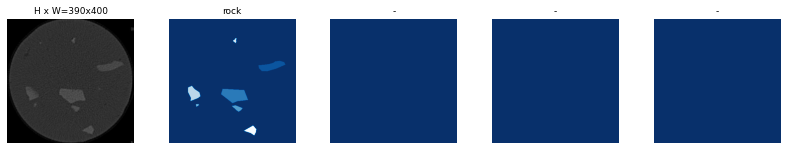

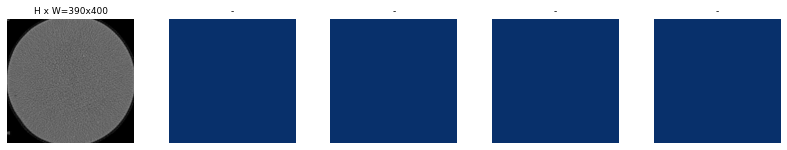

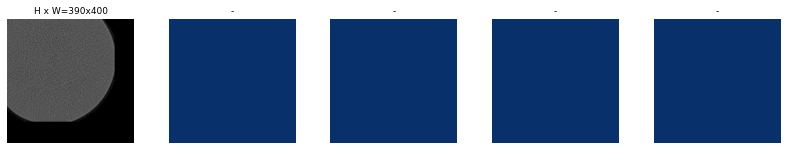

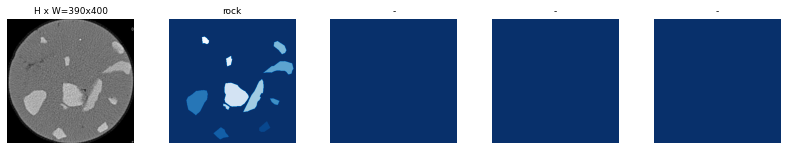

In [10]:
# 加载并展示随机的一个示例
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Create Model

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
# 以哪种权重开始训练
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    # model.load_weights(model.find_last()[1], by_name=True)
    last_weights_path = './logs/shapes20210913T0755/mask_rcnn_shapes_0046.h5'
    model.load_weights(last_weights_path, by_name=True)


Re-starting from epoch 46


# 训练

time:1h 45m

In [ ]:
# 仅训练head分支
# 传递layer="all"训练所有层。也可以传递一个正则表达式来选择哪些层，按名称模式训练。
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=20,
            layers='heads')




Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/mask rcnn_test/logs/shapes20210913T0755/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
98/99 [============================>.] - ETA: 2s - loss: 1.2638 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 0.3187 - mrcnn_class_loss: 0.2110 - mrcnn_bbox_loss: 0.2674 - mrcnn_mask_loss: 0.4088

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


99/99 [==============================] - 352s - loss: 1.2627 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 0.3202 - mrcnn_class_loss: 0.2105 - mrcnn_bbox_loss: 0.2675 - mrcnn_mask_loss: 0.4069 - val_loss: 1.2008 - val_rpn_class_loss: 0.0512 - val_rpn_bbox_loss: 0.3230 - val_mrcnn_class_loss: 0.2262 - val_mrcnn_bbox_loss: 0.2359 - val_mrcnn_mask_loss: 0.3645
Epoch 2/20
99/99 [==============================] - 215s - loss: 0.9827 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.2374 - mrcnn_class_loss: 0.1734 - mrcnn_bbox_loss: 0.1923 - mrcnn_mask_loss: 0.3395 - val_loss: 1.0991 - val_rpn_class_loss: 0.0415 - val_rpn_bbox_loss: 0.2933 - val_mrcnn_class_loss: 0.2073 - val_mrcnn_bbox_loss: 0.1782 - val_mrcnn_mask_loss: 0.3788
Epoch 3/20
99/99 [==============================] - 267s - loss: 0.8972 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.1922 - mrcnn_class_loss: 0.1725 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3352 - val_loss: 0.9520 - val_rpn_class_loss: 0.0293 - val_rpn_bbox_loss: 0.2479 -

time:43m

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='heads')


Starting at epoch 20. LR=0.001

Checkpoint Path: /content/drive/My Drive/mask rcnn_test/logs/shapes20210913T0755/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 21/30
98/99 [============================>.] - ETA: 2s - loss: 0.3298 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.1571

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


99/99 [==============================] - 301s - loss: 0.3272 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1560 - val_loss: 0.6131 - val_rpn_class_loss: 0.0089 - val_rpn_bbox_loss: 0.1090 - val_mrcnn_class_loss: 0.1491 - val_mrcnn_bbox_loss: 0.0977 - val_mrcnn_mask_loss: 0.2484
Epoch 22/30
99/99 [==============================] - 252s - loss: 0.3269 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0360 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1681 - val_loss: 0.5872 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.1110 - val_mrcnn_class_loss: 0.1417 - val_mrcnn_bbox_loss: 0.0706 - val_mrcnn_mask_loss: 0.2554
Epoch 23/30
99/99 [==============================] - 255s - loss: 0.3082 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.1606 - val_loss: 0.5238 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.0992

time：80m
17 epochs

In [ ]:
# 微调所有的层
# 传递layer="all"训练所有层。也可以传递一个正则表达式来选择哪些层，按名称模式训练。
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=60,
            layers="all")


Starting at epoch 30. LR=0.0001

Checkpoint Path: /content/drive/My Drive/mask rcnn_test/logs/shapes20210913T0755/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 31/60
98/99 [============================>.] - ETA: 2s - loss: 0.2165 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.1109

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


99/99 [==============================] - 308s - loss: 0.2176 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.1114 - val_loss: 0.3935 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.0851 - val_mrcnn_class_loss: 0.0759 - val_mrcnn_bbox_loss: 0.0496 - val_mrcnn_mask_loss: 0.1737
Epoch 32/60
99/99 [==============================] - 270s - loss: 0.2213 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.1188 - val_loss: 0.4496 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.0962 - val_mrcnn_class_loss: 0.0866 - val_mrcnn_bbox_loss: 0.0536 - val_mrcnn_mask_loss: 0.2073
Epoch 33/60
99/99 [==============================] - 270s - loss: 0.2091 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.1102 - val_loss: 0.5362 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.1080

保存模型权重

In [ ]:
# 保存权重
# 通常不需要，因为回调会在每个 epoch 之后保存checkpoint
model_save_path = os.path.join(MODEL_DIR, "mask_rcnn_rock.h5")
model.keras_model.save_weights(model_save_path)

In [ ]:
!tensorboard --logdir=logs/shapes20210911T1629 --host=127.0.0.1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# Detection

In [13]:
class InferenceConfig(RockConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# 重建一个推理模式的模型
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# 得到权重保存的路径
# 设置特定路径或查找最后训练的权重
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = './logs/mask_rcnn_rock.h5'

# 加载训练好的权重
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  ./logs/mask_rcnn_rock.h5


### 预测、对比

In [14]:
dataset_test_root_path="final_detection_rock_dataset/"
test_img_floder = dataset_test_root_path + "imgs/"
test_mask_floder = dataset_test_root_path + "mask/"
test_yaml_floder = dataset_test_root_path + "yaml/"
test_imglist = os.listdir(test_img_floder)
test_count = len(test_imglist)

In [16]:
# 验证数据集准备
dataset_test = RockDataset()
dataset_test.load_shapes(len(test_imglist), test_img_floder, test_mask_floder, test_imglist, test_yaml_floder)
dataset_test.prepare()
print("dataset_test-->",dataset_test._image_ids)

print("Prediction Image Count: {}".format(len(dataset_test.image_ids)))
print("Prediction Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
    print("{:3}. {:50}".format(i, info['name']))

dataset_test--> [0 1 2 3 4 5 6 7 8 9]
Prediction Image Count: 10
Prediction Class Count: 2
  0. BG                                                
  1. rock                                              


9
original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (13,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (13, 4)               min:  102.00000  max:  477.00000  int32
gt_mask                  shape: (512, 512, 13)        min:    0.00000  max:    1.00000  uint8


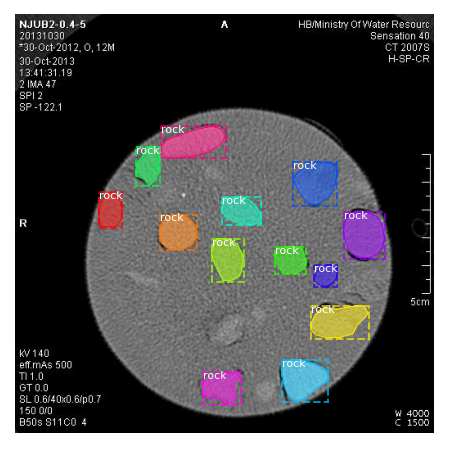

In [21]:
# 随机测试一张图片
image_id = 9
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


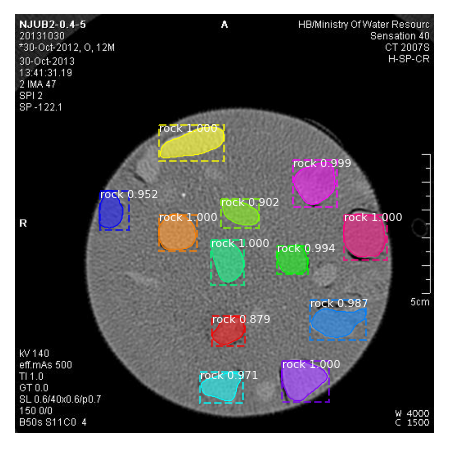

In [22]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# Evaluation

In [23]:
# Compute VOC-Style mAP @ IoU=0.5
# 运行10张图片，增加数量已获得更好的准确性
image_ids = np.random.choice(dataset_test.image_ids, 10)
APs = []
for image_id in image_ids:
    # 加载图像和gt真实数据
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # 预测
    results = model.detect([image], verbose=0)
    r = results[0]
    # 计算AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7467308334241827
